In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random

In [9]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Regular Data

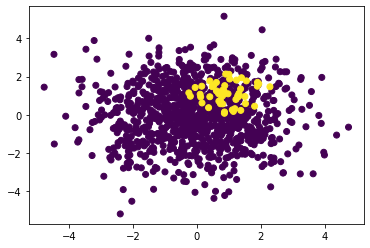

In [10]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [1.0, 1.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

In [11]:
input_size = 2
hidden_size = 12
output_size = 2

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [12]:
epochs = 10000
learning_rate = 0.01

## ERM

In [13]:
criterion = nn.CrossEntropyLoss()

0.949751615524292
0.1250734031200409
0.12057312577962875
0.11815382540225983
0.11685791611671448
0.11605340242385864
0.11568409949541092
0.11541594564914703
0.115211620926857
0.11502785235643387
Final loss:  0.11485955864191055


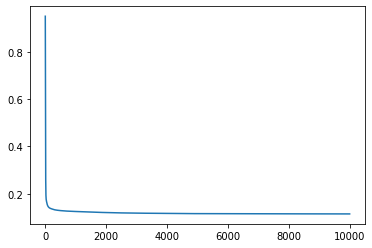

In [14]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    
model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

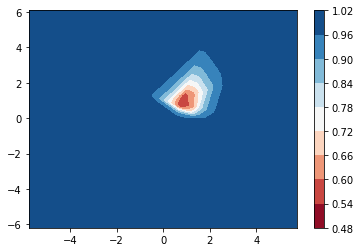

In [15]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

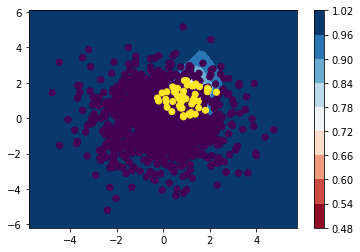

In [16]:
# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu', vmax=1.0)
# add a legend, called a color bar
plt.colorbar(c)
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    plt.scatter(X[:,0], X[:,1], c=y)

tensor([   0,    0,    0,  ..., 1050, 1050, 1050])
True


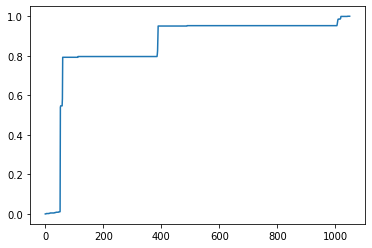

In [17]:
output = model(inputs)
# output = torch.log(output)

criterion = nn.CrossEntropyLoss(reduction='none')

loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
sorted_loss, indices = torch.sort(loss, dim=0, descending=False, stable=True)
empirical_cdf = np.array(np.searchsorted(indices, range(len(loss)))) / len(loss)
print(np.searchsorted(indices, range(len(loss))))
# empirical_cdf = np.array(indices) / len(loss)
sorted_loss_idxs = sorted(range(len(loss)), key=lambda k: loss[k])
# for i in range(len(loss)):2q
#     print(sorted_loss_idxs[i], indices[i])
#     print(sorted_loss_idxs[i] == indices[i])
print(np.all(np.array(sorted_loss_idxs) == indices.detach().numpy()))
# print(loss, '\n')
plt.plot(empirical_cdf)
# loss = loss.detach().numpy()

# plt.hist(loss)

## HRM

In [20]:
class HRMLoss(nn.Module):
    def __init__(self, a=0.4, b=0.3, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        assert(reduction == 'none' or reduction == 'mean' or reduction == 'sum')
        super().__init__()
        self.a = a
        self.b = b
        self.reduction = reduction
        self.criterion = criterion
      
    def _cpt_poly(self, a, b, Fx):
        return (3 - 3 * b) / (a**2 - a + 1) * (Fx**3 - (a + 1) * Fx**2 + a * Fx) + Fx

    def _cpt_poly_derivative(self, a, b, Fx):
        return (3 - 3 * b) / (a**2 - a + 1) * (3 * Fx**2 - 2 * (a + 1) * Fx + a) + 1

    def forward(self, output, labels):
        loss = self.criterion(output, labels)

        empirical_cdf = torch.argsort(torch.argsort(loss, dim=0, descending=False)) / len(loss)
    
        weighted_cdf = torch.Tensor(self._cpt_poly_derivative(self.a, self.b, empirical_cdf))

        # Test to check equivalence of just using optimizer.step rather than manually multiplying the loss gradient by the weigth constant.
#         print('before', loss)
#         loss.register_hook(lambda grad: print('grad', grad, weighted_cdf*grad))
#         loss.mean().backward(retain_graph=True)
#         print('weight', weighted_cdf)
        loss *= weighted_cdf
#         print('after', loss)
#         loss.mean().backward()
        if self.reduction == 'mean':
            return torch.mean(loss)
        elif self.reduction == 'sum':
            return torch.sum(loss)
        return loss

1.0940932035446167
0.2564861476421356
0.2516036629676819
0.25021737813949585
0.24942609667778015
0.2488696277141571
0.2482897937297821
0.2477140873670578
0.2468087375164032
0.2453860342502594
Final loss:  0.24429818987846375


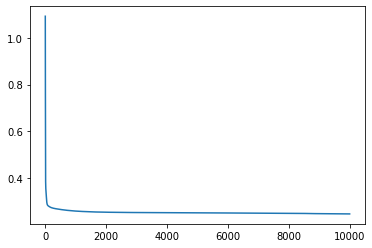

In [19]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = HRMLoss()

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
#     output = torch.log(output)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

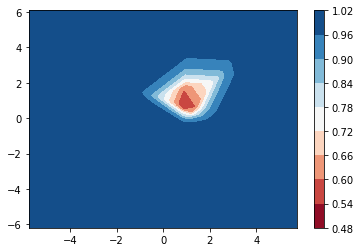

In [165]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

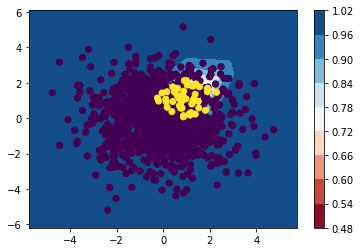

In [166]:
# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    plt.scatter(X[:,0], X[:,1], c=y)

# Random Labels

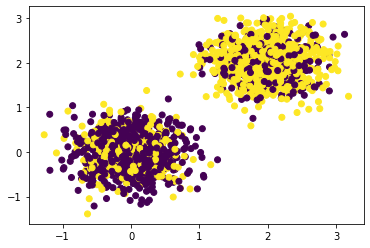

In [167]:
n_samples_1 = 1000
n_samples_2 = 1000
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Randomly flip a percentage of labels
percent = 0.3
n = len(y)
y_orig = np.array(list(y))
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y_orig = y_orig.reshape(-1, 1)
y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels_orig = torch.tensor(y_orig, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

## ERM

0.6921635866165161
0.5992536544799805
0.5981003046035767
0.5973489284515381
0.5969398021697998
0.5967457890510559
0.5966655015945435
0.5966095924377441
0.596565842628479
0.5965371131896973
Final loss:  0.5965016484260559


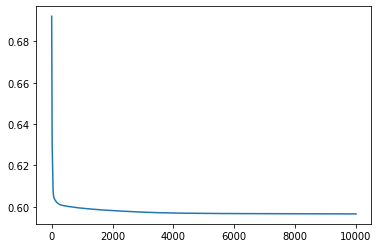

In [168]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = nn.CrossEntropyLoss()
model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

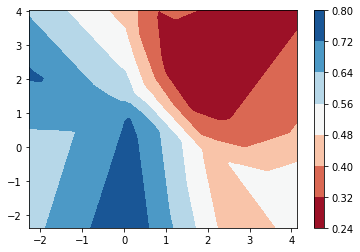

In [169]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

Num losses > 0.4: (1, 83)


(0.0, 2000.0)

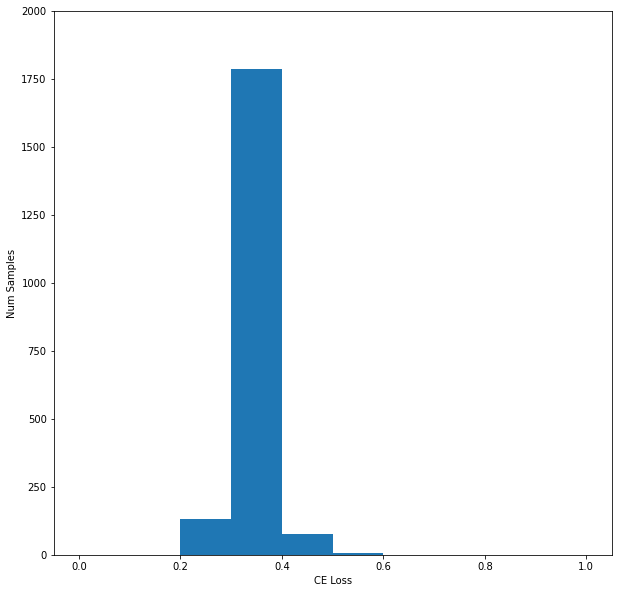

In [174]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels_orig.squeeze(1).type(torch.LongTensor))
    print('Num losses > 0.4:', np.array(np.where(loss > 0.4)).shape)
    losses.append(loss)
    
plt.figure(figsize=(10,10))
plt.xlabel('CE Loss')
plt.ylabel('Num Samples')

plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 2000))

## HRM

0.7299816608428955
0.6390270590782166
0.638384222984314
0.6380146741867065
0.6378018260002136
0.6375807523727417
0.6374403238296509
0.6372888684272766
0.6371670961380005
0.6370468735694885
Final loss:  0.6369325518608093


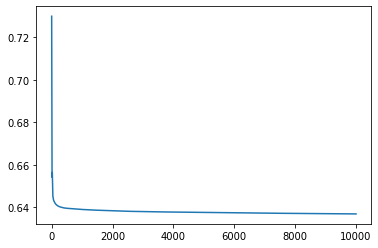

In [181]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = HRMLoss(b=0.8)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

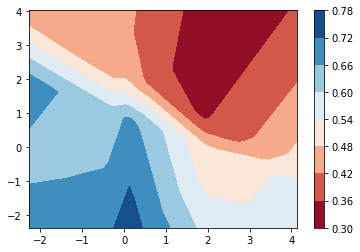

In [182]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

(1, 1392)


(0.0, 2000.0)

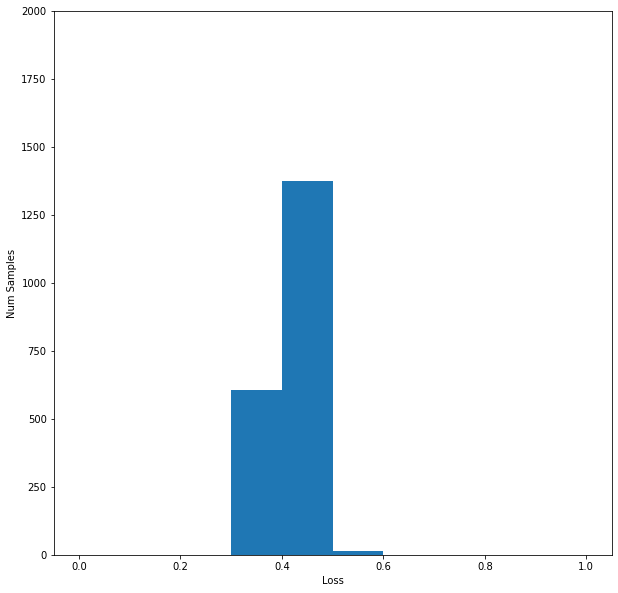

In [183]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    output = model(inputs)

    loss = criterion(output, labels_orig.squeeze(1).type(torch.LongTensor))
    losses.append(loss)
    print(np.array(np.where(loss > 0.4)).shape)

plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 2000))

# Class Imbalance

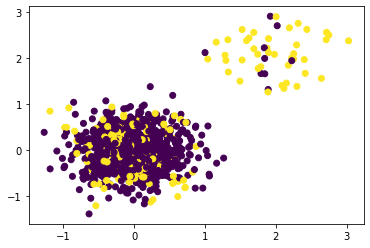

In [109]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Randomly flip a percentage of labels
percent = 0.2
n = len(y)
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

## ERM

0.7799533009529114
0.4881599247455597
0.4863467216491699
0.4858417510986328
0.48476070165634155
0.4840072989463806
0.48343604803085327
0.4829331636428833
0.4825221300125122
0.4821930527687073
Final loss:  0.4818079471588135


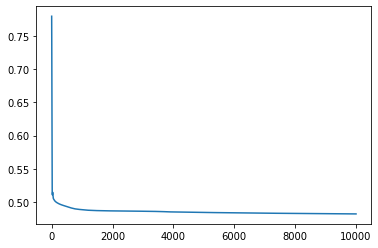

In [110]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = nn.CrossEntropyLoss()
model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

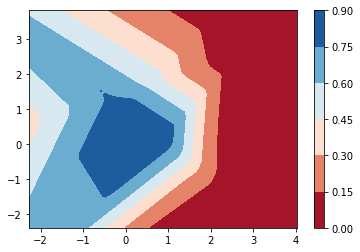

In [111]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

Num losses > 0.4: (1, 210)


(array([  8., 370., 441.,  21.,   5.,   4.,   1.,   0.,   1.,   4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

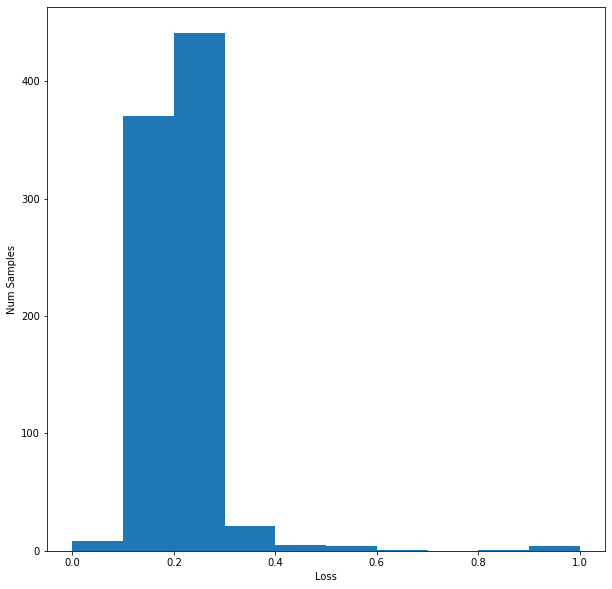

In [112]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    print('Num losses > 0.4:', np.array(np.where(loss > 0.4)).shape)
    losses.append(loss)

plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 1050))

## HRM

0.8015902042388916
0.6517205834388733
0.6449489593505859
0.6301434636116028
0.6204211711883545
0.6180087924003601
0.6162170767784119
0.6151273250579834
0.6136886477470398
0.608957827091217
Final loss:  0.6069638133049011


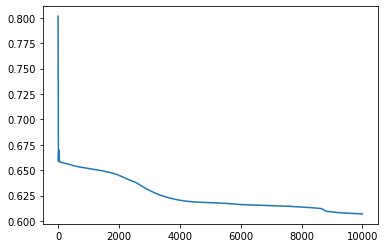

In [113]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = HRMLoss()

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

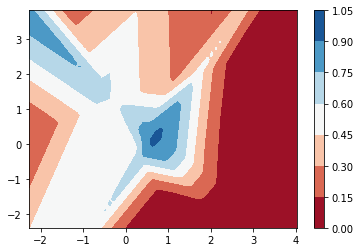

In [114]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# Fair Regression

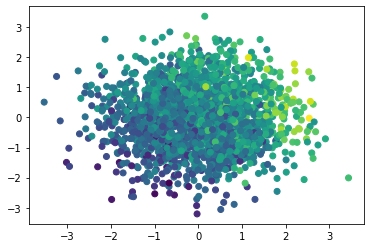

In [22]:
num_train = 2000
DATA_DIM = 5

X_train = np.random.normal(loc=0, scale=1, size=(num_train, DATA_DIM))
eps_train = np.random.normal(loc=0, scale=0.01, size=(num_train, 1))

theta = np.array([1 for _ in range(DATA_DIM)])
y_train = np.array([X_train[i].dot(theta) + eps_train[i] if X_train[i][0] <= 1.645 else X_train[i].dot(theta) + X_train[i][0] + eps_train[i] for i in range(num_train)])

plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

y_train = y_train.reshape(-1, 1)
inputs = torch.tensor(X_train, dtype=torch.float)
labels = torch.tensor(y_train, dtype=torch.float)

In [23]:
print(labels)

tensor([[-0.3936],
        [-4.7220],
        [ 0.6986],
        ...,
        [-0.4012],
        [-1.5154],
        [-1.5908]])


In [24]:
num_test = 20000

X_test = np.random.normal(loc=0, scale=1, size=(num_test, DATA_DIM))
eps_test = np.random.normal(loc=0, scale=0.01, size=(num_test, 1))

theta = np.array([1 for _ in range(DATA_DIM)])
is_majority = [False if X_test[i][0] > 1.645 else True for i in range(num_test)]
y_test = np.array([X_test[i].dot(theta) + eps_test[i] if X_test[i][0] <= 1.645 else X_test[i].dot(theta) + X_test[i][0] + eps_test[i] for i in range(num_test)])
y_test = y_test.reshape(-1, 1)

In [25]:
input_size = DATA_DIM
h1 = 50
h2 = 25
epochs = 200

class RegressionMLP(nn.Module):
    def __init__(self, input_size, h1, h2):
        super(RegressionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## ERM

In [28]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

5.212076187133789
Final training loss:  0.058227378875017166
Majority Risk: 0.04671740159392357
Minority Risk: 0.4666004478931427


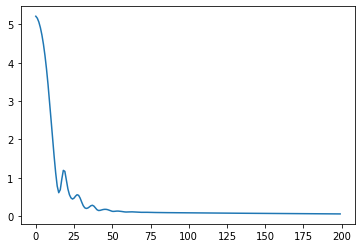

In [29]:
criterion = nn.MSELoss(reduction='mean')

model = RegressionMLP(input_size, h1, h2)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.type(torch.float32))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final training loss: ", losses[-1])
plt.plot(losses)

model.eval()
majority_losses = []
minority_losses = []

with torch.no_grad():
    for i, sample in enumerate(list(zip(X_test, y_test))):
        X, y = sample
        output = model(torch.tensor(X, dtype=torch.float32))
        # negative likelihood (expected risk)
        loss = criterion(output, torch.tensor(y, dtype=torch.float32))
        if is_majority[i]:
            majority_losses.append(loss)
        else:
            minority_losses.append(loss)
            
erm_majority_risk = torch.mean(torch.tensor(majority_losses)).item()
erm_minority_risk = torch.mean(torch.tensor(minority_losses)).item()
print('Majority Risk:', erm_majority_risk)
print('Minority Risk:', erm_minority_risk)

## HRM

Final training loss for a=0.5 b=0.0: 0.08938469737768173
Majority Risk For a=0.5, b=0.0: 0.039992041885852814
Minority Risk For a=0.5, b=0.0: 0.3216320872306824
Final training loss for a=0.5 b=0.2: 0.08318435400724411
Majority Risk For a=0.5, b=0.2: 0.040506456047296524
Minority Risk For a=0.5, b=0.2: 0.33316436409950256
Final training loss for a=0.5 b=0.4: 0.07777192443609238
Majority Risk For a=0.5, b=0.4: 0.042253121733665466
Minority Risk For a=0.5, b=0.4: 0.3472916781902313
Final training loss for a=0.5 b=0.6: 0.07107765227556229
Majority Risk For a=0.5, b=0.6: 0.04346229508519173
Minority Risk For a=0.5, b=0.6: 0.3697487413883209
Final training loss for a=0.5 b=0.8: 0.06455670297145844
Majority Risk For a=0.5, b=0.8: 0.045002929866313934
Minority Risk For a=0.5, b=0.8: 0.40269410610198975
Final training loss for a=0.5 b=1.0: 0.058227378875017166
Majority Risk For a=0.5, b=1.0: 0.04671740159392357
Minority Risk For a=0.5, b=1.0: 0.4666004478931427


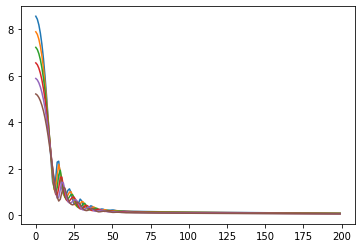

In [36]:
a = 0.5
B = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
# B = [1.0]

majority_risks = []
minority_risks = []

for b in B:
    # Reset random seeds for comparaison.
    SEED = 15
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

    criterion = HRMLoss(a=a, b=b, criterion=nn.MSELoss(reduction='none'))

    model = RegressionMLP(input_size, h1, h2)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    losses = []

    for epoch in range(epochs):
        # clear the gradients so they wont accumulate
        optimizer.zero_grad()

        output = model(inputs)
        # negative likelihood (expected risk)
        loss = criterion(output.squeeze(1), labels.squeeze(1).type(torch.float32))
        losses.append(loss.item())

        # calculate gradient
        loss.backward()

        # gradient descent
        optimizer.step()

    print("Final training loss for a={} b={}: {}".format(a, b, losses[-1]))
    plt.plot(losses)

    model.eval()
    majority_losses = []
    minority_losses = []
    
    criterion = nn.MSELoss(reduction='mean')

    with torch.no_grad():
        for i, sample in enumerate(list(zip(X_test, y_test))):
            X, y = sample
            output = model(torch.tensor(X, dtype=torch.float32))
            # negative likelihood (expected risk)
            loss = criterion(output, torch.tensor(y, dtype=torch.float32))
            if is_majority[i]:
                majority_losses.append(loss)
            else:
                minority_losses.append(loss)

    majority_risks.append(torch.mean(torch.tensor(majority_losses)).item())
    minority_risks.append(torch.mean(torch.tensor(minority_losses)).item())
    
    print('Majority Risk For a={}, b={}: {}'.format(a, b, majority_risks[-1]))
    print('Minority Risk For a={}, b={}: {}'.format(a, b, minority_risks[-1]))

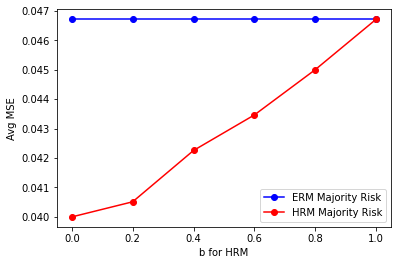

In [37]:
plt.plot(B, [erm_majority_risk for _ in range(len(majority_risks))], marker='o', color='b', label='ERM Majority Risk')
plt.plot(B, majority_risks, marker='o', color='r', label='HRM Majority Risk')
plt.xlabel('b for HRM')
plt.ylabel('Avg MSE')
plt.legend()

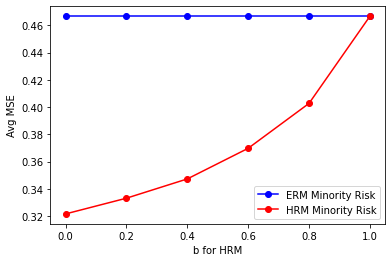

In [38]:
plt.plot(B, [erm_minority_risk for _ in range(len(minority_risks))], marker='o', color='b', label='ERM Minority Risk')
plt.plot(B, minority_risks, marker='o', color='r', label='HRM Minority Risk')
plt.xlabel('b for HRM')
plt.ylabel('Avg MSE')
plt.legend()